Home Budget
-----

In [1]:
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from google_auth_oauthlib import flow
from apiclient.discovery import build
import sklearn as sk

import config.settings as settings

SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]
URL = 'https://sheets.googleapis.com/v4/spreadsheets/' + settings.SPREADSHEET_ID

def parse_google_auth(file):
  """
  parse_goole_auth(file)
  :param: file is a String with a path (relative or absolute) to the given JSON file.

  This function requires a JSON file for a specific Google OAuth user.
  This can be received from the Google Cloud Console for the linked project.
  """
  log("Loading Google Sheet... ", end="")
  try:
    saved_token = open('config/token.bin', 'rb')
    creds = pickle.load(saved_token)
    log("Saved token found")
  except FileNotFoundError:
    saved_token = open('config/token.bin', 'wb+')
    auth_flow = flow.InstalledAppFlow.from_client_secrets_file(file, scopes=SCOPES)
    creds = auth_flow.run_local_server(open_browser=True)
    pickle.dump(creds, saved_token)
    log("New token saved")
  finally:
    saved_token.close()

  service = build('sheets', 'v4', credentials=creds)
  return service

def get_sheet_values(file_id=settings.SPREADSHEET_ID):
  service = parse_google_auth("config/oauth2.json")
  log("Getting sheet values:")
  return_values = {}
  for range_string in settings.SHEET_NAMES:
    log("\t {}... ".format(range_string), end="")
    request = service.spreadsheets().values().batchGet(
        spreadsheetId=settings.SPREADSHEET_ID, ranges=range_string)
    response = request.execute()
    values = response['valueRanges'][0]['values']
    return_values[range_string] = values
    log("done")
  return return_values

def log(string, end='\n'):
    '''
    For backwards compatibility
    '''
    print(string)
    
vals = get_sheet_values()

Loading Google Sheet... 
Saved token found
Getting sheet values:
	 Transactions... 
done
	 Categories... 
done
	 Balance History... 
done


In [2]:
plt.style.use('seaborn')

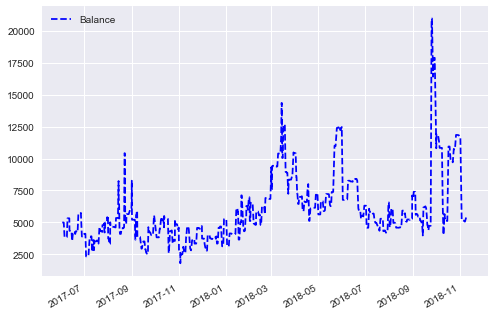

In [3]:
bal_hist = pd.DataFrame(vals['Balance History'][1:], columns=vals['Balance History'][0][:-1])
bal_hist.set_index(pd.to_datetime(bal_hist.pop('Date') + ' ' + bal_hist.pop('Time')), inplace=True)
bal_hist['Balance'] = pd.to_numeric(bal_hist['Balance'].str.replace('$', '').str.replace(',', ''))
bal_hist = bal_hist[bal_hist['Balance'] != 0]
bal_hist[bal_hist['Account #'] == 'xxxx6947'][:'1971-01-01'].plot(style='b--')

In [4]:
txns = pd.DataFrame(vals['Transactions'][1:], columns=vals['Transactions'][0])
txns.set_index('Date', inplace=True)
txns = pd.concat([txns.pop('Amount').str.replace('$', '').str.replace(',','').astype(float), txns], axis=1)

In [5]:
dom = pd.Series(pd.to_datetime(txns.index), index=txns.index).dt.day
dom_analysis = pd.concat([dom, txns['Amount']], axis=1)
dom_analysis

,Date,Amount
Date,,
11/9/2018,9,-115.39
11/9/2018,9,-211.54
11/9/2018,9,-110.79
11/9/2018,9,-19.49
11/9/2018,9,30.00
11/9/2018,9,1576.20
11/9/2018,9,19.49
11/8/2018,8,-15.10
11/8/2018,8,-755.35


In [6]:
bins = pd.Series(np.logspace(1, 4.4, num=200))
bins = pd.concat([-bins, bins]).sort_values()
bins
txn_bins = pd.get_dummies(pd.cut(txns['Amount'], bins))
txn_bins.describe()
txn_cats = pd.get_dummies(txns['Category'])
txn_analysis = pd.concat([txn_cats, txn_bins], axis=1)
correlation = txn_analysis.corr(method='spearman').iloc[:-1*(len(bins)-1),-1*(len(bins)-1):]
sig_correlation = correlation[correlation > 0.4].dropna(axis=1, how='all').dropna(axis=0, how='all')

In [7]:
txns[txns['Category'] == '']

,Amount,Description,Category,Note,Account,Account #,Institution,Month,Week,Transaction ID,Check Number,Full Description,Date Added
Date,,,,,,,,,,,,,
11/9/2018,-115.39,Americanexpress Transfer,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be567aa4f0d2e00206307fe,,AMERICANEXPRESS TRANSFER,11/9/2018
11/9/2018,-211.54,Americanexpress Transfer,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be567aa4f0d2e0020630800,,AMERICANEXPRESS TRANSFER,11/9/2018
11/9/2018,-110.79,Americanexpress Transfer,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be567aa4f0d2e0020630804,,AMERICANEXPRESS TRANSFER,11/9/2018
11/9/2018,-19.49,Canseco's Metairie Mmetairie LA x x5979,,,CC - Blue Cash (AMEX),xxxx1002,American Express Cards,2018-11-01,2018-11-04,5be761d7e6663b001befbbee,,CANSECO'S METAIRIE MMETAIRIE LA xxxxxxxxx xxxx...,11/10/2018
11/9/2018,30.00,Deposit Mobile Banking,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be751f5320a96001cf186df,,Deposit Mobile Banking,11/10/2018
11/9/2018,1576.20,Esi Dir Dep xx1103~ Tran: Achdd,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be567aa4f0d2e0020630802,,ESI DIR DEP xx1103~ Tran: ACHDD,11/9/2018
11/9/2018,19.49,Online Payment - Thank You,,,CC - Blue Cash (AMEX),xxxx1002,American Express Cards,2018-11-01,2018-11-04,5be761d7e6663b001befbbec,,ONLINE PAYMENT - THANK YOU,11/10/2018
11/8/2018,-15.10,Aetna Rx Home Delivery,,,CC - Freedom Unlimited (Chase),xxxx0619,Chase - Credit Card,2018-11-01,2018-11-04,5be53426da2629001bb59e30,,AETNA RX HOME DELIVERY,11/9/2018
11/8/2018,-755.35,Citi Card Online Payment xx1107,,,Checking - Joint (Schwab),xxxx6947,Charles Schwab - Bank,2018-11-01,2018-11-04,5be567aa4f0d2e00206307fc,,CITI CARD ONLINE PAYMENT xx1107,11/9/2018


In [8]:
txn_analysis = txns[['Category', 'Amount']][txns['Category'] != '']
txn_corr = pd.concat([txn_analysis, pd.get_dummies(txn_analysis.pop('Category')), pd.get_dummies(txn_analysis.pop('Amount'))], axis=1)
# txn_corr.corr(method='spearman', min_periods=2)